In [2]:
import numpy as np  # Import numpy for numerical operations
import matplotlib.pyplot as plt  # Import matplotlib for creating plots
import pandas as pd  # Import pandas for handling tabular data
import seaborn as sns  # Import seaborn for advanced data visualization
from sklearn.model_selection import train_test_split  # Import function to split data into training and testing sets
from sklearn.linear_model import LogisticRegression  # Import logistic regression model
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis  # Import linear discriminant analysis
from sklearn.neighbors import KNeighborsClassifier  # Import k-nearest neighbors classifier
from sklearn.naive_bayes import GaussianNB  # Import Gaussian Naive Bayes classifier
from sklearn.metrics import (  # Import performance evaluation metrics
    accuracy_score,  # To calculate accuracy
    confusion_matrix,  # To compute confusion matrices
    roc_curve,  # To generate ROC curves
    roc_auc_score,
    auc# To calculate the area under the ROC curve
)
from sklearn.preprocessing import StandardScaler  # Import scaler for standardizing features
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Part 1: Analyzing the Base

1.	Explore the design of the household database : a priori , what variables do you think could be predictive of unemployment and would be useful to include to improve the TP3 exercise? Mention these variables and justify your choice. 


### Part 1, Question 2a

2a. Eliminate all observations that do not correspond to the agglomerations of the Autonomous City of Buenos Aires (CABA) or the Parties of Greater Buenos Aires, and merge both quarters into a single base.  Based on the questions being asked in the remainder of the document and your warning to make sure we use the CODUSU and NRO Hogar variables for the merge, I believe you are asking us to merge the individual and household data into a single dataframe, then concatenate them vertically.


In [3]:
# Load the 2004 data from a Stata (.dta) file into a pandas DataFrame
T1_2004_hogar = pd.read_stata('Hogar_t104.dta')
T1_2004_individual = pd.read_stata('Individual_t104.dta')

# Load the 2024 data from an Excel (.xlsx) file into a pandas DataFrame
T1_2024_hogar = pd.read_excel('usu_hogar_T124.xlsx')
T1_2024_individual = pd.read_excel('usu_individual_T124.xlsx')


In [4]:
''' The problem here is that while the human readable information is convenient
    for us, it's not helpful in the analysis later, because the xlsx derived data
    comes over as code.  Instead of conversion on a case by case basis, we'll just
    use the stata key-value pairs and map the labels back to the codes'''

def convert_labels_to_codes(df, stata_file_path):
    """
    Converts human-readable labels in a Stata DataFrame to numerical codes using
    the value labels from the Stata file.

    Parameters:
    df (pd.DataFrame): DataFrame with human-readable labels.
    stata_file_path (str): Path to the original Stata file.

    Returns: pd.DataFrame: DataFrame with labels replaced by their corresponding numerical codes"""
    # Access value labels in the Stata file
    with pd.io.stata.StataReader(stata_file_path) as reader:  # Open the Stata file in read mode
        value_labels = reader.value_labels()  # Extract value labels (human-readable to code mapping)

    # Loop through each column in the DataFrame
    for column in df.columns:
        if column in value_labels:  # Check if the column has associated value labels
            label_mapping = {v: k for k, v in value_labels[column].items()}  # Reverse mapping (label -> code)
            
            # Check if the column is a categorical type
            if pd.api.types.is_categorical_dtype(df[column]):
                # Rename categories in the column using the label-to-code mapping
                df[column] = df[column].cat.rename_categories(label_mapping)
            else:
                # Map values directly for non-categorical columns and fill any missing mappings
                df[column] = df[column].map(label_mapping).fillna(df[column])

    return df  # Return the modified DataFrame

# Apply the conversion function to the 2004 dataset
T1_2004_hogar = convert_labels_to_codes(T1_2004_hogar, 'Hogar_t104.dta')
T1_2004_individual = convert_labels_to_codes(T1_2004_individual, 'Individual_t104.dta')


C:\Users\Eugenia Saini\AppData\Local\Temp\ipykernel_12404\140142369.py:26: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df[column]):


In [5]:
''' Codigo de Aglomerado CABA = 32 and Partidos del GBA Codigo de Aglomerado = 33, pandas extracts that from the dta code.'''

''' This function will filter and return a dataframe with only the rows containing the information we want.  Doing this ahead of time to make sure we 
    get ALL of the aglomerado data before we eliminate duplicate columns.'''

''' To merge the data into a single dataframe as per this question we have two steps:
    1.  Select only the rows of data where the region and aglomerado match our criteria
    2.  Merging the dataframes where the column names don't match will yield none/NaN values
        in the rows from the years that don't have them.  We need to filter those columns out
        before we merge; there's no point in keeping those since we cannot compare NaN's.
        If we want to keep that data, there's already a copy - the original dataframe for that year'''

''' For real world use, you would also want to convert the data in the new dataframe to the same format
    2004 is more human readable than 2024.  This is complicated by the fact that census data codes and
    categories often change over time.  However, that is not being asked for in this homework'''


''' Selecting the rows where the region or aglomerado match our criteria'''
def filter_and_select_rows(df, filters):
    """
    Filters rows in a DataFrame based on column-value conditions using OR logic.
    Parameters:
    df (pd.DataFrame): DataFrame to filter.
    filters (dict): Dictionary specifying column-value pairs for filtering.

    Returns:
    pd.DataFrame: Filtered DataFrame containing rows that match any filter condition.
    """
    filter_condition = False  # Initialize the filter condition (logical OR of all conditions)

    # Loop through each column-value pair in the filters dictionary
    for column, value in filters.items():
        filter_condition |= (df[column] == value)  # Add condition for rows where column equals the value

    return df[filter_condition]  # Apply the filter and return the resulting DataFrame


filtered_hogar_2004 = filter_and_select_rows(T1_2004_hogar, {'aglomerado': 32, 'aglomerado': 33})
filtered_individual_2004 = filter_and_select_rows(T1_2004_individual, {'aglomerado': 32, 'aglomerado': 33})


filtered_hogar_2024 = filter_and_select_rows(T1_2024_hogar, {'AGLOMERADO': 32, 'AGLOMERADO': 33})
filtered_individual_2024 = filter_and_select_rows(T1_2024_individual, {'AGLOMERADO': 32, 'AGLOMERADO': 33})

In [6]:
''' The inner join produces the cartesian product of the two sets; it returns all possible row values for a unique key, including any information that is double-recorded.  We solve this with drop duplicates.  Now the two dataframes have been joined by the unique key of CODUSU and nro_hogar'''
T1_2004 = pd.merge(filtered_hogar_2004, filtered_individual_2004, on = ["CODUSU", "nro_hogar"], how = "inner").drop_duplicates()
T1_2024 = pd.merge(filtered_hogar_2024, filtered_individual_2024, on = ["CODUSU", "NRO_HOGAR"], how = "inner").drop_duplicates()

In [7]:
''' The stata column names from 2004 are in lower case, and those from 2024 are in upper case. Python is case-sensitive, and treated the lower case and upper case versions of the column names as DIFFERENT COLUMNS - even though we know they are the same, the computer thinks they are different, because each character has a different assigned numerical byte sequence; e.g. S and s are not numerically the same
    for the computer. So we converted the column names to the same format.  The line of code below sets the column names in 2004 to the upper case version, to match those from 2024. That lets us concatenate the now-matched column names properly. Just to be sure we converted the T1_2024 as well, to avoid any weird behavior from the join.'''

T1_2004.columns = T1_2004.columns.str.upper()
T1_2024.columns = T1_2024.columns.str.upper()

In [8]:
''' CODUSU between 2004 and 2024 are not compatible. In 2004 is a 6 digit string, and 2024 is a 29 character string; the last 6 digits of the 29 character string match that of the 2004 format. To make them compatible, we extracted only the final six digits of the 2024 string, and drop the rest of the characters. We accomplished this simply with string slicing and then assigning the results back to the column itself'''

T1_2024["CODUSU"] = T1_2024["CODUSU"].str[-6:]

In [9]:
''' Now we need to compare the column names to see if there are columns in 2004 that are not in 2024 and vice-versa. The easiest way to do this is to grab the column names as an unordered set, then use the subtraction operator for set comparison, as per the below. This lets us drop any columns they do not have in common.'''

def compare_columns(df1, df2):
    """
    Compare column names from two DataFrames and find columns that are not in both.

    Parameters:
    df1 (pd.DataFrame): The first DataFrame.
    df2 (pd.DataFrame): The second DataFrame.

    Returns:
    tuple: Two lists of column names:
           - Columns only in df1.
           - Columns only in df2.
    """
    # Get the column names as sets
    columns_df1 = set(df1.columns)
    columns_df2 = set(df2.columns)
    
    # Find differences
    only_in_df1 = list(columns_df1 - columns_df2)  # Columns in df1 but not in df2
    only_in_df2 = list(columns_df2 - columns_df1)  # Columns in df2 but not in df1

    return only_in_df1, only_in_df2


In [10]:
''' This returns what is in each dataframe that IS NOT in the other one'''
drop_2004, drop_2024 = compare_columns(T1_2004, T1_2024)
print(drop_2004, drop_2024)

''' Now we dropped the columns from their respective dataframes. Notice - we're passing LISTS to the Pandas method here. Pandas does this a lot - you pass the lists of things, not the thing - so if you're doing one column, it has to be a list with just the one column in it...'''
dropped_2004 = T1_2004.drop(columns=drop_2004)
dropped_2024 = T1_2024.drop(columns=drop_2024)

''' Just as a check, we printed the number of columns in each dataframe - they should match now and as we can see they are both 87'''

print(len(dropped_2004.columns), len(dropped_2024.columns))

['PJ3_1', 'PJ2_1', 'PJ1_1', 'IDIMPH', 'IDIMPP'] ['PONDIIO', 'PONDII', 'IMPUTA', 'PONDIH_Y', 'CH05', 'PONDIH_X']
257 257


In [11]:
''' And now we concatenate the dataframes on the vertical axis, stacking the rows on top of each other, since the 
    columns match. We ignore the index so it will assign a new set of index numbers and there will be no
    index number conflicts'''

df_2004_24 = pd.concat([dropped_2004, dropped_2024], ignore_index=True, axis = 0)



### Part 1, Question 3

3. Clean the database using criteria that make sense. Explain any decisions such as the treatment of missing values , outliers , or categorical variables. Justify your decisions. 

In [12]:
print (len(df_2004_24))
df_2004_24.isna().sum()

11440


CODUSU            0
NRO_HOGAR         0
REALIZADA         0
ANO4_X            0
TRIMESTRE_X       0
               ... 
IDECCFR_Y      5629
RDECCFR_Y         0
GDECCFR_Y         0
PDECCFR_Y      5629
ADECCFR_Y         0
Length: 257, dtype: int64

In [13]:
''' The above examination of the NaNs shows that discarding all observations (rows) containing a NaN would make the data useless - about
    half the data would go missing.  These NaN's however, appear in only a subset of the columns and are consistent in number, 
    suggesting that the data simply was uncollected in those columns, over the same observations, for whatever reason, and numbers
    in the thousands.  Given this I would consider the data in those columns to be unreliable, and simply eliminate them, unless I 
    needed that information specifically, in which case I would turn to ways to potentially infer their values.  
    
    *** How the data is cleaned depends on what you want to do with it.  I note that these columns containing all the NaN's are 
    not needed to answer the homework questions and suitable to be dropped on that basis.  For other purposes, it might be necessary to 
    go through the database and clean it on a more discrete basis.
        The function below returns a dataframe where the columns are dropped based on a NaN threshold entered in the arguments'''

def drop_columns_with_nans(df, max_nans):
    """
    Drops columns with more than a specified threshold of NaN values.

    Parameters:
    df (pd.DataFrame): DataFrame to clean.
    max_nans (int): Maximum allowed NaN values per column.

    Returns:
    pd.DataFrame: DataFrame with columns exceeding the threshold dropped.
    """
    # Count the number of NaNs in each column
    nan_counts = df.isna().sum()

    # Identify columns with NaNs exceeding the specified threshold
    columns_to_drop = nan_counts[nan_counts > max_nans].index

    # Drop the identified columns from the DataFrame
    return df.drop(columns=columns_to_drop)

# Drop columns with more than 1000 NaN values from the combined dataset
nan_dropped_2004_24 = drop_columns_with_nans(df_2004_24, 300)

''' We can see that the number of columns after this round of data cleaning dropped from 257 to 146'''
# Print the updated number of columns after dropping
print(len(nan_dropped_2004_24.columns))



146


In [14]:
def count_nans_per_column(df):
    """
    Counts the number of NaN values in each column of a DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame to analyze.

    Returns:
    pd.Series: Series with column names as index and NaN counts as values.
    """
    # Count NaN values for each column and return the result
    nan_counts = df.isna().sum()
    return nan_counts[nan_counts > 0]

# Check for remaining columns with NaN values

'''P47T is the individual income amount, and there are 35 missing entries.  We can fill those in with the median later'''
count_nans_per_column(nan_dropped_2004_24)


P47T    35
dtype: int64

In [15]:
'''Now we'll run a search for columns containing negative numbers to see if they make sense - can only use it on numeric columns...'''

def find_columns_with_negatives(df):
    """
    Identifies numeric columns in a DataFrame that contain negative values.

    Parameters:
    df (pd.DataFrame): DataFrame to analyze.

    Returns:
    list: Names of columns containing negative values.
    """
    # Select numeric columns only
    numeric_df = df.select_dtypes(include=['number'])

    # Check for negative values and return column names
    return [col for col in numeric_df.columns if (numeric_df[col] < 0).any()]

def count_negatives_per_column(df):
    """
    Counts the number of negative values in each numeric column.

    Parameters:
    df (pd.DataFrame): DataFrame to analyze.

    Returns:
    pd.Series: Series with column names as index and count of negative values as values.
    """
    # Select numeric columns only
    numeric_df = df.select_dtypes(include=['number'])

    # Count the number of negative values per column
    return (numeric_df < 0).sum()

In [16]:
'''There are several columns with negative values. The codes show them to be income related. We can fill these with medians'''
count_negatives_per_column(nan_dropped_2004_24)

NRO_HOGAR        0
REALIZADA        0
ANO4_X           0
TRIMESTRE_X      0
REGION_X         0
              ... 
V19_AM           0
V21_M           48
T_VI           240
ITF_Y            0
IPCF_Y           0
Length: 119, dtype: int64

In [17]:
''' The negative columns were income or time related.  The use of medians vs means is preferable in this instance because means can be skewed by outliers; the median is more likely to reflect the data accurately since it is not affected so much.'''
def fill_na_and_negatives_with_median_preserve(df):
    """
    Replaces NaN and negative values in numeric columns with the median
    of the non-negative, non-NaN values in the column. Non-numeric columns remain unchanged.

    Parameters:
    df (pd.DataFrame): DataFrame to clean.

    Returns:
    pd.DataFrame: Cleaned DataFrame with replaced values.
    """
    # Create a copy of the DataFrame to avoid modifying the original
    df_copy = df.copy()

    # Select numeric columns
    numeric_columns = df_copy.select_dtypes(include=['number']).columns

    # Loop through each numeric column
    for column in numeric_columns:
        # Exclude NaN and negative values to calculate the median
        valid_values = df_copy[column][(df_copy[column] >= 0) & (df_copy[column].notna())]
        median_value = valid_values.median()

        # Replace NaN and negative values with the median
        df_copy[column] = df_copy[column].apply(lambda x: median_value if pd.isna(x) or x < 0 else x)

    return df_copy

# Replace NaNs and negative values with median in the dataset
cleaned_2004_24 = fill_na_and_negatives_with_median_preserve(nan_dropped_2004_24)



### Part 1, Question 4

4.	Construct variables (minimum 3) that are not in the (individual) base but are relevant to predict unemployed individuals (for example, the proportion of people working at home).

In [18]:
'''Answers in the document'''

'Answers in the document'

### Part 1, Question 5

5.	Present descriptive statistics of three variables from the household survey that you believe may be relevant for predicting unemployment . Comment on the statistics obtained.

In [19]:
def descriptive_statistics(df, columns):
    """     Calculate descriptive statistics for specified columns in a DataFrame.
    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - columns (list): List of column names for which to calculate statistics.

    Returns:
    - pd.DataFrame: A DataFrame containing descriptive statistics for each column.
    """
    stats = []

    for col in columns:
        if col not in df.columns:
            stats.append({"Column": col, "Statistic": "Error", "Value": f"Column '{col}' not found"})
            continue

        if pd.api.types.is_numeric_dtype(df[col]):
            # Numerical column statistics
            stats.extend([
                {"Column": col, "Statistic": "Count", "Value": df[col].count()},
                {"Column": col, "Statistic": "Mean", "Value": df[col].mean()},
                {"Column": col, "Statistic": "Standard Deviation", "Value": df[col].std()},
                {"Column": col, "Statistic": "Min", "Value": df[col].min()},
                {"Column": col, "Statistic": "25%", "Value": df[col].quantile(0.25)},
                {"Column": col, "Statistic": "Median (50%)", "Value": df[col].median()},
                {"Column": col, "Statistic": "75%", "Value": df[col].quantile(0.75)},
                {"Column": col, "Statistic": "Max", "Value": df[col].max()},
            ])
        elif pd.api.types.is_categorical_dtype(df[col]) or pd.api.types.is_object_dtype(df[col]):
            # Categorical column statistics
            mode_value = df[col].mode().iloc[0] if not df[col].mode().empty else None
            mode_count = df[col].value_counts().iloc[0] if not df[col].value_counts().empty else 0
            stats.extend([
                {"Column": col, "Statistic": "Count", "Value": df[col].count()},
                {"Column": col, "Statistic": "Unique", "Value": df[col].nunique()},
                {"Column": col, "Statistic": "Top (Most Frequent)", "Value": mode_value},
                {"Column": col, "Statistic": "Frequency of Top", "Value": mode_count},
            ])
        else:
            # Unsupported column type
            stats.append({"Column": col, "Statistic": "Error", "Value": "Unsupported column type"})

    # Convert stats list to a DataFrame
    return pd.DataFrame(stats)

'''This is the code to bring the three variables asked in question 5'''
filtered_hogar_2024.columns = filtered_hogar_2024.columns.str.upper()
descriptive_statistics(filtered_hogar_2024,['V1','IV12_3','ITF'])


,Column,Statistic,Value
0,V1,Count,1.881000e+03
1,V1,Mean,1.207868e+00
2,V1,Standard Deviation,5.600739e-01
3,V1,Min,1.000000e+00
4,V1,25%,1.000000e+00
5,V1,Median (50%),1.000000e+00
6,V1,75%,1.000000e+00
7,V1,Max,9.000000e+00
8,IV12_3,Count,1.881000e+03
9,IV12_3,Mean,1.993089e+00


In [20]:
# Compute descriptive statistics
stats_df = descriptive_statistics(filtered_hogar_2024, ['V1', 'IV12_3', 'ITF'])

# Pivot the DataFrame to organize by variable
stats_pivoted = stats_df.pivot(index="Statistic", columns="Column", values="Value")

# Display the result
print(stats_pivoted)

Column                       ITF       IV12_3           V1
Statistic                                                 
25%                 0.000000e+00     2.000000     1.000000
75%                 5.000000e+05     2.000000     1.000000
Count               1.881000e+03  1881.000000  1881.000000
Max                 3.393700e+07     2.000000     9.000000
Mean                3.905586e+05     1.993089     1.207868
Median (50%)        2.100000e+05     2.000000     1.000000
Min                 0.000000e+00     1.000000     1.000000
Standard Deviation  1.005000e+06     0.082868     0.560074


# PART 2: Classification and Regularization

### Part 2, Question 1

1.	For each year, split the response set into a training and test set ( X_train, y_train, X_test, y_test ) using the train_test_split command . The training set should comprise 70% of the data, and the seed to use ( random state instance ) should be 101. Set unoccupied as your dependent variable in the training set (vector y ). The rest of the variables will be the independent variables (matrix X ). Remember to add the ones column (1).

In [21]:
''' We want to predict employed vs unemployed so we need to first drop non-PEA and 0, then train on just employed vs. unemployed.
    Steps:
    1. Create the list of values to drop
    2. Use the ~ operator to reverse the meaning of .isin to is NOT in
    3. Add the Bias term
    4. OHE the variables
    5. Separate into their respective years using one of the year columns.  We could delete one of the columns but it's just one and doesn't really matter.
    6. Create test and training data for the two clean dataframes.'''

#Step 1
ESTADO_drop = [0,3,4]

#Step 2
PEA_2004_24 = cleaned_2004_24[~cleaned_2004_24['ESTADO'].isin(ESTADO_drop)]

#Step 3
PEA_2004_24["BIAS"] = 1

#Step 4
OHE_2004_24 = pd.get_dummies(PEA_2004_24)

#Step 5
clean_2004 = OHE_2004_24[OHE_2004_24["ANO4_X"] == 2004]
clean_2024 = OHE_2004_24[OHE_2004_24["ANO4_Y"] == 2024]

#Step 6
'''*** We do not have to one hot encode this and create separate columns; the data is binary after dropping codes 0, 3, 4 and the predictors will work just fine'''

# Extract dependent variable (y) and independent variables (X) for 2004

y_2004 = clean_2004["ESTADO"]
X_2004 = clean_2004.drop(["ESTADO"], axis=1)

# Extract dependent variable (y) and independent variables (X) for 2024
y_2024 = clean_2024["ESTADO"]
X_2024 = clean_2024.drop(["ESTADO"], axis=1)

# Split 2004 data into training (70%) and testing (30%) sets
X_2004_train, X_2004_test, y_2004_train, y_2004_test = train_test_split(
    X_2004, y_2004, test_size=0.3, random_state=101
)

# Split 2024 data into training (70%) and testing (30%) sets
X_2024_train, X_2024_test, y_2024_train, y_2024_test = train_test_split(
    X_2024, y_2024, test_size=0.3, random_state=101
)

# Standardize the features for both years
scaler = StandardScaler()

# Apply scaling to the training and testing sets of 2004 data
X_2004_train = scaler.fit_transform(X_2004_train)
X_2004_test = scaler.transform(X_2004_test)

# Apply scaling to the training and testing sets of 2024 data
X_2024_train = scaler.fit_transform(X_2024_train)
X_2024_test = scaler.transform(X_2024_test)



C:\Users\Eugenia Saini\AppData\Local\Temp\ipykernel_12404\1314195697.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  PEA_2004_24["BIAS"] = 1
C:\Users\Eugenia Saini\AppData\Local\Temp\ipykernel_12404\1314195697.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PEA_2004_24["BIAS"] = 1


### Part 2, Question 2
2.	Briefly explain how you would choose λ by cross-validation (in Python it is alpha). Explain why you would not use the test set for your choice.

In [22]:
''' You don't use your test set because it's the test set - the point is to train a predictor; exposing the predictor
    to information contained in your test set during the cross-validation means it can't be used for testing - the predictor
    runs the risk of overfitting/memorizing attributes of the test data instead of actually predicting.  And I would do it
    exactly like the code below:'''

X = X_2004_train  # Features from 2004
y = y_2004_train  # Target labels from 2004

# Define a range of alpha (lambda) values.  We search in logspace because its way more efficient than searching in linspace;
# The linear differences between alphas/lambdas can be small in a logistic regression; log space search allows coverage of much
# greater absolute values with fewer numbers to test.
alphas = np.logspace(-4, 4, 10)

# Set up K-Fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=101)

# Dictionary to store cross-validation scores
cv_scores = {}

# Perform cross-validation for each alpha - note this uses ridge regularization.... L2 is way more expensive than L1 though...
# There's a reason LASSO is a go-to for many really big problems.
for alpha in alphas:
    model = LogisticRegression(penalty='l2', solver='liblinear', C=1/alpha)  # C = 1/lambda
    scores = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')  # Adjust scoring as needed
    cv_scores[alpha] = np.mean(scores)

# Find the best alpha
best_alpha = max(cv_scores, key=cv_scores.get)

# Output results
print("Best alpha (lambda):", best_alpha)
print("Best cross-validation score:", cv_scores[best_alpha])

Best alpha (lambda): 0.046415888336127774
Best cross-validation score: 1.0


### Part 2, Question 3
3.	In cross-validation, what are the implications of using a very small or a very large k ? When k = n (with n being the number of samples), how many times is the model estimated?

All cross validations are a form of "leave one out."  If I have k = 5, then I divide my data into 5 sets, and use the other four, over 5 iterations, to predict the value of the set "left out."  As a consequence, cross validation proceeds in O(k) time, where k is the number of folds.  If k = 10, then you have 10 sets, leave out one, and use the remaining 9 to predict the 10th, iteratively (e.g., leaving out set 1, then 2, then 3, etc).  When k = 5, I effectively use 80% of my data to validate the remaining 20% at each iteration.  When k = 10, I'm using 90% of my data on each iteration to predict the remaining 10.  When k = 20, this is 95 to 5, etc.  The problem with small values of k is that, while cheaper, has high bias since the folds are big.  The trade off is that the variance is lower.  Very large values of k mean that you're going to have high variance, since the test data in each iteration is such a small portion of the data set.  The ultimate version of this is k = n, which is colloquially referred to as "leave one out CV," because it leaves out ONLY 1 sample for each iteration and uses the other data to estimate it.  This means the cross validation proceeds in nearly quadratic time O(2) and is prohibitive except in the smallest cases - the cross validation occurs at n^2.

 ### Part 2, Question 4.

4.	For logistic regression, implement the penalty, L1 as LASSO and L2 as Ridge λ=1 (as in Tutorial 10) , using the penalty option and report the confusion matrix, ROC curve, AUC and Accuracy values for each year.  How did the results change from TP3? Is the performance of logistic regression with regularization better or worse?

The actual coding and results are below.  The results are better than the logistic regression from TP3, showing greater accuracy and lower confusion.  That's exactly why regularization is used - it generalizes better based on the data because it does not let outlier results overly impact the estimator.

In [23]:
# Step 1.1: Train Lasso model for 2004
lasso_2004 = LogisticRegression(penalty='l1', solver='liblinear', C=1.0)  # C = 1/lambda
lasso_2004.fit(X_2004_train, y_2004_train)

# Step 1.2: Predict and evaluate on 2004 test set
y_2004_pred = lasso_2004.predict(X_2004_test)
y_2004_proba = lasso_2004.predict_proba(X_2004_test)[:, 1]

def confusion_matrix_to_dataframe(matrix, model_type, year):
    df = pd.DataFrame(matrix, 
                      index=["True Negative", "True Positive"], 
                      columns=["Predicted Negative", "Predicted Positive"])
    df.index.name = f"{model_type} {year} Confusion Matrix"
    return df

# Step 1.3: Metrics for 2004
conf_matrix_2004 = confusion_matrix(y_2004_test, y_2004_pred)
fpr_2004, tpr_2004, _ = roc_curve(y_2004_test, y_2004_proba, pos_label=2)
roc_auc_2004 = auc(fpr_2004, tpr_2004)
accuracy_2004 = accuracy_score(y_2004_test, y_2004_pred)

# Display results for 2004
print("2004 Lasso Results:")
conf_matrix_2004_df = pd.DataFrame(conf_matrix_2004, 
                                   index=["True Negative", "True Positive"], 
                                   columns=["Predicted Negative", "Predicted Positive"])
conf_matrix_2004_df.index.name = "Lasso 2004 Confusion Matrix"
print(conf_matrix_2004_df)
print(f"Accuracy: {accuracy_2004:.4f}")
print(f"AUC: {roc_auc_2004:.4f}")

# Step 1.4: Train Lasso model for 2024
lasso_2024 = LogisticRegression(penalty='l1', solver='liblinear', C=1.0)  # C = 1/lambda
lasso_2024.fit(X_2024_train, y_2024_train)

# Step 1.5: Predict and evaluate on 2024 test set
y_2024_pred = lasso_2024.predict(X_2024_test)
y_2024_proba = lasso_2024.predict_proba(X_2024_test)[:, 1]

# Step 1.6: Metrics for 2024
conf_matrix_2024 = confusion_matrix(y_2024_test, y_2024_pred)
fpr_2024, tpr_2024, _ = roc_curve(y_2024_test, y_2024_proba, pos_label=2)
roc_auc_2024 = auc(fpr_2024, tpr_2024)
accuracy_2024 = accuracy_score(y_2024_test, y_2024_pred)

# Display results for 2024
print("\n2024 Lasso Results:")
conf_matrix_2024_df = pd.DataFrame(conf_matrix_2024, 
                                   index=["True Negative", "True Positive"], 
                                   columns=["Predicted Negative", "Predicted Positive"])
conf_matrix_2024_df.index.name = "Lasso 2024 Confusion Matrix"
print(conf_matrix_2024_df)
print(f"Accuracy: {accuracy_2024:.4f}")
print(f"AUC: {roc_auc_2024:.4f}")

# Step 2.1: Train Ridge model for 2004
ridge_2004 = LogisticRegression(penalty='l2', solver='liblinear', C=1.0)  # C = 1/lambda
ridge_2004.fit(X_2004_train, y_2004_train)

# Step 2.2: Predict and evaluate on 2004 test set
y_2004_pred_ridge = ridge_2004.predict(X_2004_test)
y_2004_proba_ridge = ridge_2004.predict_proba(X_2004_test)[:, 1]

# Step 2.3: Metrics for 2004
conf_matrix_2004_ridge = confusion_matrix(y_2004_test, y_2004_pred_ridge)
fpr_2004_ridge, tpr_2004_ridge, _ = roc_curve(y_2004_test, y_2004_proba_ridge, pos_label=2)
roc_auc_2004_ridge = auc(fpr_2004_ridge, tpr_2004_ridge)
accuracy_2004_ridge = accuracy_score(y_2004_test, y_2004_pred_ridge)

# Display results for 2004
print("\n2004 Ridge Results:")
print("Confusion Matrix:\n", conf_matrix_2004_ridge)
conf_matrix_2004_ridge_df = pd.DataFrame(conf_matrix_2004_ridge, 
                                         index=["True Negative", "True Positive"], 
                                         columns=["Predicted Negative", "Predicted Positive"])
conf_matrix_2004_ridge_df.index.name = "Ridge 2004 Confusion Matrix"
print(conf_matrix_2004_ridge_df)
print(f"AUC: {roc_auc_2004_ridge:.4f}")

# Step 2.4: Train Ridge model for 2024
ridge_2024 = LogisticRegression(penalty='l2', solver='liblinear', C=1.0)  # C = 1/lambda
ridge_2024.fit(X_2024_train, y_2024_train)

# Step 2.5: Predict and evaluate on 2024 test set
y_2024_pred_ridge = ridge_2024.predict(X_2024_test)
y_2024_proba_ridge = ridge_2024.predict_proba(X_2024_test)[:, 1]

# Step 2.6: Metrics for 2024
conf_matrix_2024_ridge = confusion_matrix(y_2024_test, y_2024_pred_ridge)
fpr_2024_ridge, tpr_2024_ridge, _ = roc_curve(y_2024_test, y_2024_proba_ridge, pos_label=2)
roc_auc_2024_ridge = auc(fpr_2024_ridge, tpr_2024_ridge)
accuracy_2024_ridge = accuracy_score(y_2024_test, y_2024_pred_ridge)

# Display results for 2024
print("\n2024 Ridge Results:")
conf_matrix_2024_ridge_df = pd.DataFrame(conf_matrix_2024_ridge, 
                                         index=["True Negative", "True Positive"], 
                                         columns=["Predicted Negative", "Predicted Positive"])
conf_matrix_2024_ridge_df.index.name = "Ridge 2024 Confusion Matrix"
print(conf_matrix_2024_ridge_df)
print(f"Accuracy: {accuracy_2024_ridge:.4f}")
print(f"AUC: {roc_auc_2024_ridge:.4f}")

2004 Lasso Results:
                             Predicted Negative  Predicted Positive
Lasso 2004 Confusion Matrix                                        
True Negative                               683                   0
True Positive                                 0                 112
Accuracy: 1.0000
AUC: 1.0000

2024 Lasso Results:
                             Predicted Negative  Predicted Positive
Lasso 2024 Confusion Matrix                                        
True Negative                               735                   0
True Positive                                 5                  79
Accuracy: 0.9939
AUC: 0.9994

2004 Ridge Results:
Confusion Matrix:
 [[683   0]
 [  0 112]]
                             Predicted Negative  Predicted Positive
Ridge 2004 Confusion Matrix                                        
True Negative                               683                   0
True Positive                                 0                 112
AUC: 1.0000

2024 Ridg

 ### Part 2, Question 5.
5.	Perform a sweep at λ= 10 n with n ∈ {−5, −4, −3 ..., +4, +5} and use 10-fold CV to choose the λoptimum in logistic regression with Ridge and with LASSO. What λdid you choose in each case? Using the seaborn library , generate a box plot showing the distribution of the prediction error for each λ. Each box must correspond to a value of λand contain as observations the mean validation error (MSE) for each partition. Also, for LASSO regularization, generate a line plot of the average of the proportion of variables ignored by the model as a function of λ(as you saw in tutorial 10), that is, the proportion of variables for which the associated coefficient is zero.  

In [24]:
# Convert X and y to numpy arrays for compatibility with KFold indices
X = np.array(X_2004_train)  # Convert features to numpy array
y = np.array(y_2004_train)  # Convert target labels to numpy array

# Define the range of λ = 10^n for n ∈ {-5, -4, ..., +4, +5}
lambdas = [10**n for n in range(-5, 6)]

# Set up 10-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=101)

# Function to perform cross-validation for a given penalty
def cross_validate_penalty(penalty):
    results = []  # To store results for boxplot
    ignored_coefficients = []  # To track proportion of ignored coefficients (for LASSO)

    for lambda_ in lambdas:
        C = 1 / lambda_
        model = LogisticRegression(penalty=penalty, solver='liblinear', C=C, max_iter=1000)
        mse_scores = []
        ignored_vars = []

        for train_idx, val_idx in kfold.split(X):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            # Fit the model
            model.fit(X_train, y_train)

            # Predict and calculate MSE
            y_pred = model.predict(X_val)
            mse = mean_squared_error(y_val, y_pred)
            mse_scores.append(mse)

            # Track ignored variables for LASSO
            if penalty == 'l1':
                num_ignored = np.sum(model.coef_ == 0)
                prop_ignored = num_ignored / len(model.coef_[0])
                ignored_vars.append(prop_ignored)

        # Store results for this λ
        results.append({'lambda': lambda_, 'MSE': np.mean(mse_scores)})

        # Store ignored variable proportions (for LASSO)
        if penalty == 'l1':
            ignored_coefficients.append({'lambda': lambda_, 'ignored_proportion': np.mean(ignored_vars)})

    return results, ignored_coefficients

# Cross-validate for Ridge (L2) and LASSO (L1)
ridge_results, _ = cross_validate_penalty('l2')
lasso_results, lasso_ignored = cross_validate_penalty('l1')

# Convert results to DataFrame for visualization
ridge_df = pd.DataFrame(ridge_results)
lasso_df = pd.DataFrame(lasso_results)
lasso_ignored_df = pd.DataFrame(lasso_ignored)

# Find best λ for Ridge and LASSO
best_lambda_ridge = ridge_df.loc[ridge_df['MSE'].idxmin(), 'lambda']
best_lambda_lasso = lasso_df.loc[lasso_df['MSE'].idxmin(), 'lambda']

print(f"Best λ for Ridge: {best_lambda_ridge}")
print(f"Best λ for LASSO: {best_lambda_lasso}")

ridge_df['Penalty'] = 'Ridge'
lasso_df['Penalty'] = 'LASSO'
combined_df = pd.concat([ridge_df, lasso_df])

# Convert λ to a string representation for better x-axis labeling
combined_df['lambda_str'] = combined_df['lambda'].apply(lambda x: f"{x:.1e}")

# Ensure proper sorting of lambdas for better visualization
combined_df['lambda_order'] = combined_df['lambda']
combined_df = combined_df.sort_values(by='lambda_order')




Best λ for Ridge: 0.01
Best λ for LASSO: 0.01


C:\Users\Eugenia Saini\AppData\Local\Temp\ipykernel_12404\2297631541.py:7: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(x='lambda_str', y='MSE', hue='Penalty', data=combined_df,


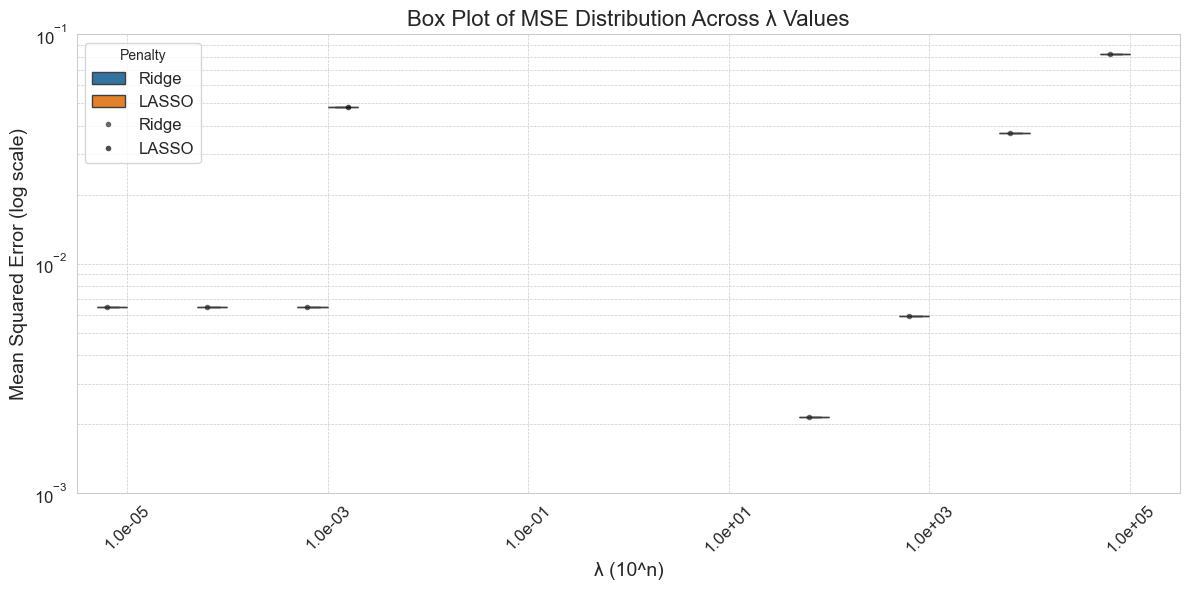

In [25]:
# Adjust y-axis scale for better readability
plt.figure(figsize=(12, 6))

sns.boxplot(x='lambda_str', y='MSE', hue='Penalty', data=combined_df, showfliers=False, width=0.6)

# Add individual data points for clarity
sns.stripplot(x='lambda_str', y='MSE', hue='Penalty', data=combined_df, 
              dodge=True, size=4, color='black', alpha=0.7, marker='o', linewidth=0)

# Improve x-axis labels: Show every second tick to reduce clutter
plt.xticks(ticks=range(0, len(lambdas), 2), labels=[f"{lambdas[i]:.1e}" for i in range(0, len(lambdas), 2)], rotation=45)

# Add gridlines
plt.grid(visible=True, which="both", linestyle="--", linewidth=0.5)

# Update scale and titles
plt.yscale('log')  # Use log scale for the y-axis
plt.ylim(1e-3, 1e-1)  # Focus y-axis range to 1e-3 to 1e-1 for better readability
plt.title('Box Plot of MSE Distribution Across λ Values', fontsize=16)
plt.xlabel('λ (10^n)', fontsize=14)
plt.ylabel('Mean Squared Error (log scale)', fontsize=14)
plt.tick_params(axis='both', labelsize=12)
plt.legend(title='Penalty', fontsize=12, loc='upper left')

plt.tight_layout()  # Adjust layout for better visualization
plt.show()




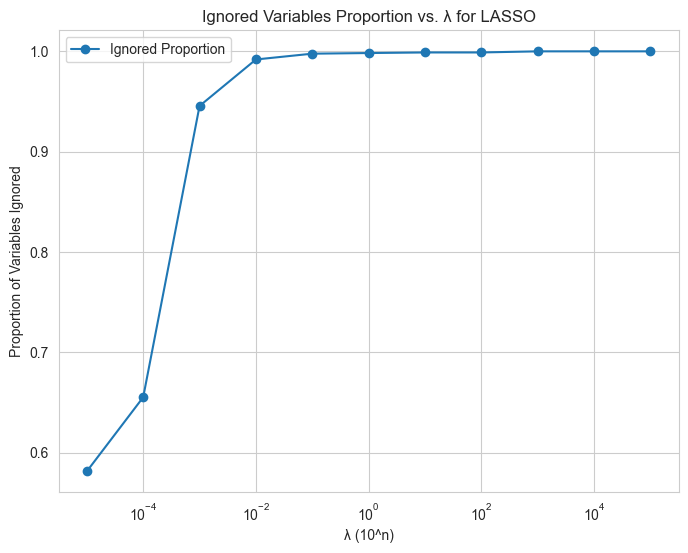

In [26]:
# Plot the ignored proportion for LASSO
plt.figure(figsize=(8, 6))
plt.plot(lasso_ignored_df['lambda'], lasso_ignored_df['ignored_proportion'], marker='o', label='Ignored Proportion')
plt.xscale('log')
plt.title('Ignored Variables Proportion vs. λ for LASSO')
plt.xlabel('λ (10^n)')
plt.ylabel('Proportion of Variables Ignored')
plt.legend()
plt.show()

 ### Part 2, Question 6.	
6. In the case of the optimal value of λ For LASSO found in the previous section, what variables were discarded? 
Are they the ones you would have expected? Is it related to what you answered in section 1 of Part I?

In [ ]:
best_C = 1 / best_lambda_lasso  # Convert λ to C
final_lasso_model = LogisticRegression(penalty='l1', solver='liblinear', C=best_C, max_iter=1000)
final_lasso_model.fit(X_2004_train, y)


# Predict using the final Lasso model
y_pred = final_lasso_model.predict(X_2004_test)

# Calculate the Mean Squared Error
mse = mean_squared_error(y_2004_test, y_pred)

# Print the Mean Squared Error
print(f"Mean Squared Error (MSE): {mse}")
# Ensure proper mapping of indices to original feature names
original_feature_names = X_2004.columns  # Get original column names from X_2004

# Get indices of zero and non-zero coefficients
coef = final_lasso_model.coef_[0]
ignored_feature_indices = np.where(coef == 0)[0]
selected_feature_indices = np.where(coef != 0)[0]

# Map indices to original feature names
ignored_features = [original_feature_names[i] for i in ignored_feature_indices]
selected_features = [original_feature_names[i] for i in selected_feature_indices]

# Create a DataFrame to display ignored and selected features
feature_df = pd.DataFrame({
    "Ignored Features": ignored_features + [None] * (len(selected_features) - len(ignored_features)),
    "Selected Features": selected_features + [None] * (len(ignored_features) - len(selected_features))
})

# Display the DataFrame
feature_df


In [62]:
best_C = 1 / best_lambda_lasso  # Convert λ to C
final_lasso_model = LogisticRegression(penalty='l1', solver='liblinear', C=best_C, max_iter=20)
final_lasso_model.fit(X_2024_train, y_2024_train)

# Predict using the final Lasso model
y_pred = final_lasso_model.predict(X_2024_test)

# Calculate the Mean Squared Error
mse = mean_squared_error(y_2024_test, y_pred)

# Print the Mean Squared Error
print(f"Mean Squared Error (MSE): {mse}")
# Ensure proper mapping of indices to original feature names
original_feature_names = X_2024.columns  # Get original column names from X_2004

# Get indices of zero and non-zero coefficients
coef = final_lasso_model.coef_[0]
ignored_feature_indices = np.where(coef == 0)[0]
selected_feature_indices = np.where(coef != 0)[0]

# Map indices to original feature names
ignored_features = [original_feature_names[i] for i in ignored_feature_indices]
selected_features = [original_feature_names[i] for i in selected_feature_indices]

# Create a DataFrame to display ignored and selected features
feature_df = pd.DataFrame({
    "Ignored Features": ignored_features + [None] * (len(selected_features) - len(ignored_features)),
    "Selected Features": selected_features + [None] * (len(ignored_features) - len(selected_features))
})

# Display the DataFrame
feature_df

Mean Squared Error (MSE): 0.009768009768009768


C:\Users\Eugenia Saini\PycharmProjects\pythonProject\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,Ignored Features,Selected Features
0,REALIZADA,NRO_HOGAR
1,ANO4_X,PONDERA_X
2,TRIMESTRE_X,IV1
3,REGION_X,IV3
4,AGLOMERADO_X,IV4
...,...,...
2019,ADECCFR_Y_06,None
2020,ADECCFR_Y_07,None
2021,ADECCFR_Y_08,None
2022,ADECCFR_Y_09,None


 ### Part 2, Question 7.
 	
7.	Choose one of the logistic regression models where you have tested different regularization parameters and comment: Compare the results for 2004 versus 2024, which regularization method performed better: Ridge or LASSO? Did LASSO make a different selection of predictors in 2004 versus 2024? Comment mentioning the mean squared error (MSE).

In [ ]:
'''from part 2 question 5'''

combined_df_2004 = combined_df

# Convert X and y to numpy arrays for compatibility with KFold indices
X = np.array(X_2024_train)  # Convert features to numpy array
y = np.array(y_2024_train)  # Convert target labels to numpy array

# Define the range of λ = 10^n for n ∈ {-5, -4, ..., +4, +5}
lambdas = [10**n for n in range(-5, 6)]

# Set up 10-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=101)

# Cross-validate for Ridge (L2) and LASSO (L1)
ridge_results, _ = cross_validate_penalty('l2')
lasso_results, lasso_ignored = cross_validate_penalty('l1')

# Convert results to DataFrame for visualization
ridge_df = pd.DataFrame(ridge_results)
lasso_df = pd.DataFrame(lasso_results)
lasso_ignored_df = pd.DataFrame(lasso_ignored)

# Find best λ for Ridge and LASSO
best_lambda_ridge = ridge_df.loc[ridge_df['MSE'].idxmin(), 'lambda']
best_lambda_lasso = lasso_df.loc[lasso_df['MSE'].idxmin(), 'lambda']

print(f"Best λ for Ridge: {best_lambda_ridge}")
print(f"Best λ for LASSO: {best_lambda_lasso}")

ridge_df['Penalty'] = 'Ridge'
lasso_df['Penalty'] = 'LASSO'
combined_df_2024 = pd.concat([ridge_df, lasso_df])


In [64]:
combined_df_2024

,lambda,MSE,Penalty
0,0.00001,0.040347,Ridge
1,0.00010,0.039824,Ridge
2,0.00100,0.031962,Ridge
3,0.01000,0.023571,Ridge
4,0.10000,0.022524,Ridge
5,1.00000,0.022527,Ridge
6,10.00000,0.023050,Ridge
7,100.00000,0.024621,Ridge
8,1000.00000,0.028812,Ridge
9,10000.00000,0.069708,Ridge


In [65]:
combined_df_2004

,lambda,MSE,Penalty,lambda_str,lambda_order
0,0.00001,0.006472,Ridge,1.0e-05,0.00001
0,0.00001,0.228041,LASSO,1.0e-05,0.00001
1,0.00010,0.191866,LASSO,1.0e-04,0.00010
1,0.00010,0.006472,Ridge,1.0e-04,0.00010
2,0.00100,0.006472,Ridge,1.0e-03,0.00100
2,0.00100,0.043127,LASSO,1.0e-03,0.00100
3,0.01000,0.000000,LASSO,1.0e-02,0.01000
3,0.01000,0.000000,Ridge,1.0e-02,0.01000
4,0.10000,0.000000,LASSO,1.0e-01,0.10000
4,0.10000,0.000000,Ridge,1.0e-01,0.10000
